<div class="alert alert-info">
<b>Постройка двух моделей для компании "Работа с заботой"</b>
</div>

<div class="alert alert-info">
<b>Задача 1: предсказание уровня удовлетворённости сотрудника</b>
</div>

<div class="alert alert-info">
<b>Задача:</b>
<br>Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
<br>
<b>Данные:</b>
<br>Дано 3 таблицы 
<br>1. Файл train_job_satisfaction_rate.csv
<br>2. Файл test_features.csv
<br>3. Файл test_target_job_satisfaction_rate.csv
<br>Все 3 файла содержат одинаковые столбцы:
<br>id — уникальный идентификатор сотрудника;
<br>dept — отдел, в котором работает сотрудник;
<br>level — уровень занимаемой должности;
<br>workload — уровень загруженности сотрудника;
<br>employment_years — длительность работы в компании (в годах);
<br>last_year_promo — показывает, было ли повышение за последний год;
<br>last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
<br>supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
<br>salary — ежемесячная зарплата сотрудника;
<br>job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Импортируем библиотеки.
</div>

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install shap

In [3]:
!pip install -U scikit-learn

In [4]:
import pandas as df

import matplotlib.pyplot as pd

from matplotlib import pyplot as plt

import seaborn as sns, numpy as np

from phik import report

from phik.report import plot_correlation_matrix

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer 

from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler,RobustScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression,LinearRegression

from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings("ignore")

import shap

from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import SelectKBest, f_classif

## Загрузка данных

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Открываем файл - train_job_satisfaction_rate.csv, сохраняем его в переменную - train_job_satisfaction_rate и смотрим по нему информацию.
</div>

In [5]:
train_job_satisfaction_rate = df.read_csv('train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Таблица содержит 4000 строк и 10 столбцов. Типы столбцов соответствуют их данным. Есть пропуски. 
</div>

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Открываем файл - test_features.csv, сохраняем его в переменную - test_features и смотрим по нему информацию.
</div>

In [7]:
test_features = df.read_csv('test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Таблица имеет 2000 строк и 9 столбцов. Типы столбцов соответствуют их данным. Есть пропуски. 
</div>

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Открываем файл - test_target_job_satisfaction_rate.csv, сохраняем его в перменную - test_target_job_satisfaction_rate и смотрим по нему информацию.
</div>

In [9]:
test_target_job_satisfaction_rate = df.read_csv('test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [10]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Таблица имеет 2000 строк и 2 столбца. Типы столбцов соответствуют их данным. Пропусков нет. 
</div>

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>Было создано 3 таблицы:
<br>1. train_job_satisfaction_rate - 4000 строк и 10 столбцов.
<br>2. test_features - 2000 строк и 9 столбцов.
<br>3. test_target_job_satisfaction_rate - 2000 строк и 2 столбца.
<br>В таблицах train_job_satisfaction_rate и test_features были обнаружены пропуски. 
</div>

##  Предобработка данных

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Начинаем переработку данных таблицы - train_job_satisfaction_rate.
</div>

In [11]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [12]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [13]:
train_job_satisfaction_rate.duplicated().sum()

0

In [14]:
train_job_satisfaction_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [15]:
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [16]:
train_job_satisfaction_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [17]:
train_job_satisfaction_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [18]:
train_job_satisfaction_rate['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [19]:
train_job_satisfaction_rate['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Таблица train_job_satisfaction_rate имеет общей суммой 10 пропусков. 6 пропусков в стобце 'dept' и 4 пропуска в столбце 'level'. Пропуски будем обрабатывать в пайплайне так-что пока их не трогаем. Явных и неявных дубликатов таблица не имеет. 
</div>

In [20]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [21]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [22]:
test_features.duplicated().sum()

0

In [23]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [24]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [25]:
test_features['dept'].replace(' ', np.nan, inplace=True)
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [26]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [27]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [28]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [29]:
test_features['workload'].replace(' ', np.nan, inplace=True)
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [30]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [31]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Таблица test_features имеет общей суммой 3 пропускa типа 'nan'. 2 пропускa в стобце 'dept' и 1 пропуск в столбце 'level'. Также таблицa имеет 2 пропускa которые имею пустые значения, по одному в колонках 'workload' и 'dept', тыкие пропуски заменили на 'nan'. Пропуски будем обрабатывать в пайплайне так-что пока их не трогаем. Явных и неявных дубликатов таблица не имеет. 
</div>

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>Были переработаны 2 таблицы.
<br>train_job_satisfaction_rate имеет общей суммой 10 пропусков. Не имеет дубликатов.
<br>test_features имеет общей суммой 5 пропусков. Пропуски в виде пустой строки замененны на 'nan' Не имеет дубликатов. 
<br>Пропуски не были обработаны так-как это будет сделано в пайплайне.
</div>

##  Исследовательский анализ данных

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создаем функции для более удобного и быстрого исследовательского анализа данных (далее ИАД).
</div>

In [32]:
def data_analysis (variable, column):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Гистограмма для - {column}', fontsize=15)
    axes[0].set_ylabel('Количество', fontsize=10)
    sns.histplot(variable, bins=20, kde=True, ax=axes[0], x=column)
    axes[1].set_title(f'График ящик с усами для - {column}', fontsize=15)
    sns.boxplot(data=variable, ax=axes[1], y=column)
    axes[1].set_ylabel(column, fontsize=10)
    plt.show()
        
def radial_diagram (variable, column):
    variable[column].value_counts().plot(y='subscription_type', kind='pie',figsize=(8,8), autopct='%1.1f%%')
    pd.title(f'Диаграмма для - {column}')
    pd.ylabel("")
    pd.show()
    
def direct_diagram(variable, column):
    display(variable[column].unique())

    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=column, data=variable)
    plot.set_title(f'Рапределение по - {column}', fontsize=15)
    plot.set_xlabel('Количество', fontsize=10)
    plt.show()

line = '-'*126

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Проводим ИАД для таблицы train_job_satisfaction_rate.
</div>

In [33]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


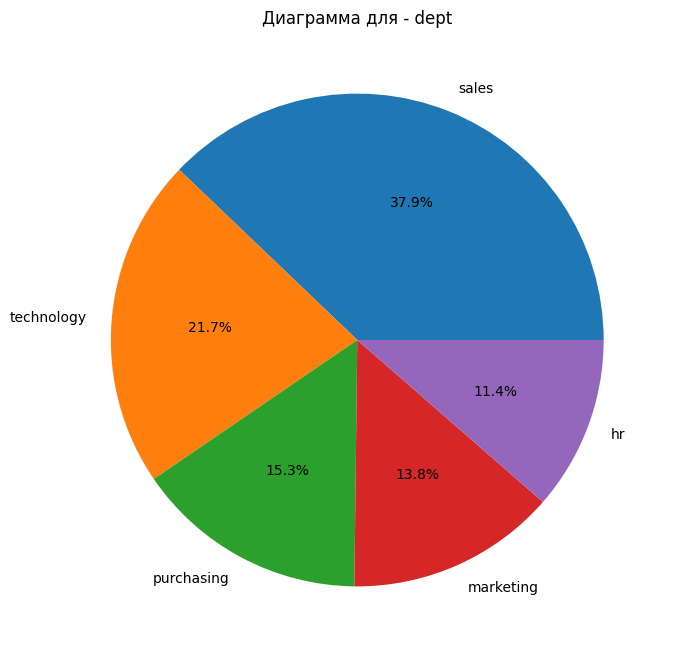

------------------------------------------------------------------------------------------------------------------------------


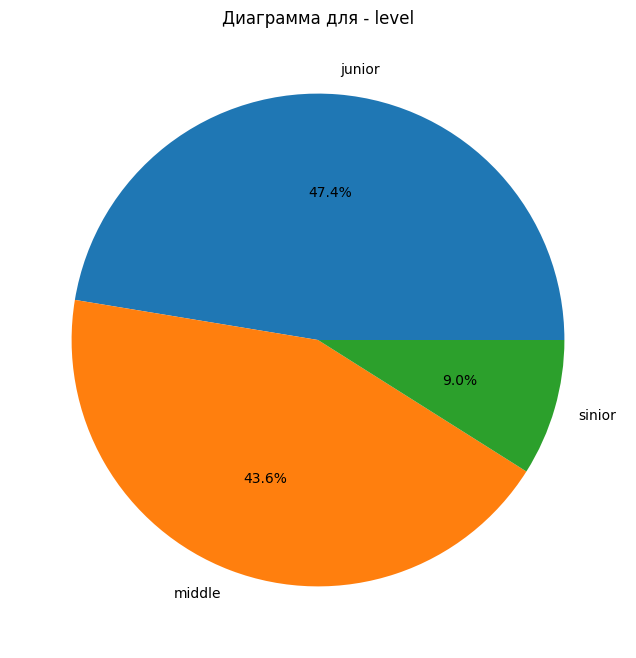

------------------------------------------------------------------------------------------------------------------------------


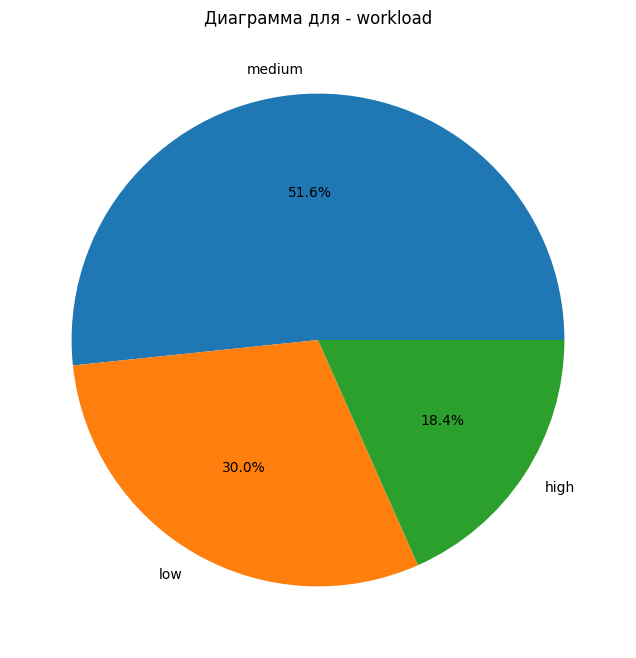

In [34]:
radial_diagram(train_job_satisfaction_rate,'dept')
print(line)
radial_diagram(train_job_satisfaction_rate,'level')
print(line)
radial_diagram(train_job_satisfaction_rate,'workload')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Столбец 'dept' - 38% сотрудников работают на должностях занимающихся товарооборотом. Меньше всего сотрудников в отледе эйчаров - 11.4%
<br>Столбец 'level' - почти половина сотрудников 47.4% занимают младшие должности. И только 9% занимают высокие. 
<br>Столбец 'workload' - половина сотрудников 51.6% считают что у них высокая загруженость на работе.
</div>

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5], dtype=int64)

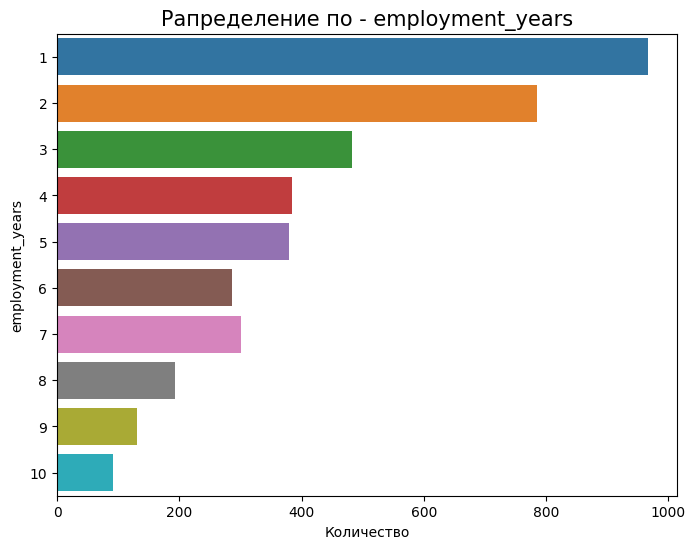

In [35]:
direct_diagram(train_job_satisfaction_rate, 'employment_years')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Большая часть сотрудников раотает в компании меньше 3х лет. В среднем стаж работы сотрудников в компании 3 года.
</div>

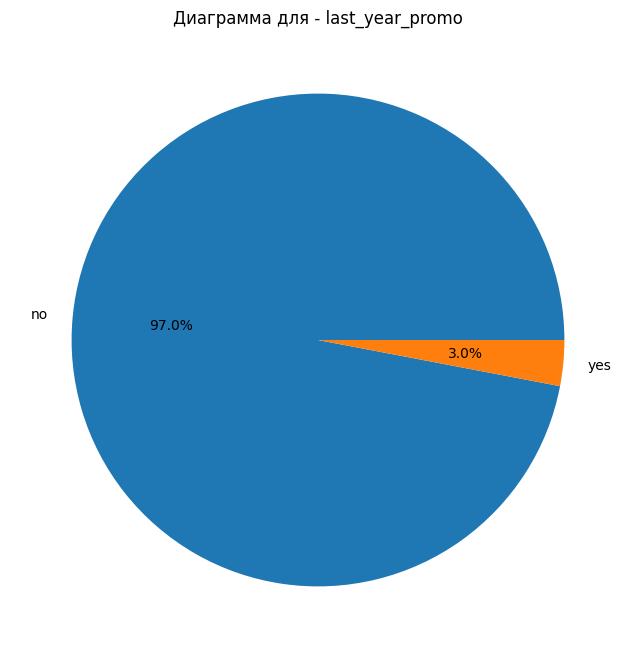

------------------------------------------------------------------------------------------------------------------------------


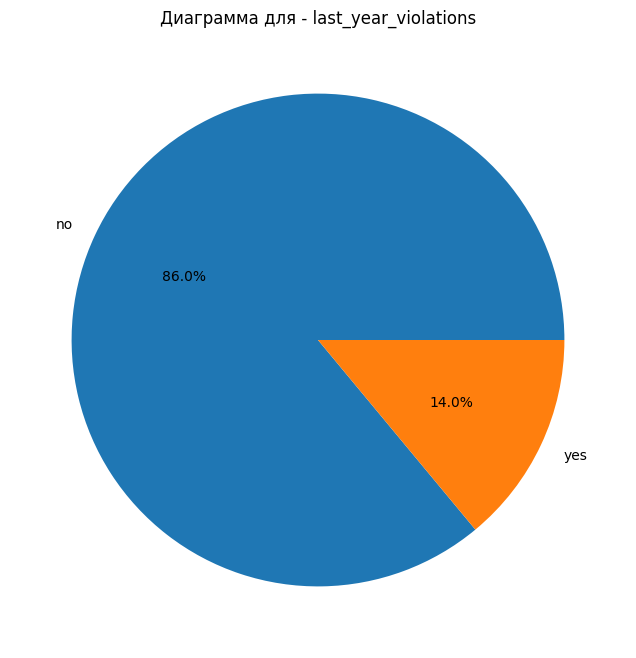

In [36]:
radial_diagram(train_job_satisfaction_rate,'last_year_promo')
print(line)
radial_diagram(train_job_satisfaction_rate,'last_year_violations')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Столбец 'last_year_promo' - только 3% сотрудников получили повышение за последний год.
<br>Столбец 'last_year_violations' -  только 14% сотрудников нарушали правила за последнй год.
</div>

array([1, 5, 2, 3, 4], dtype=int64)

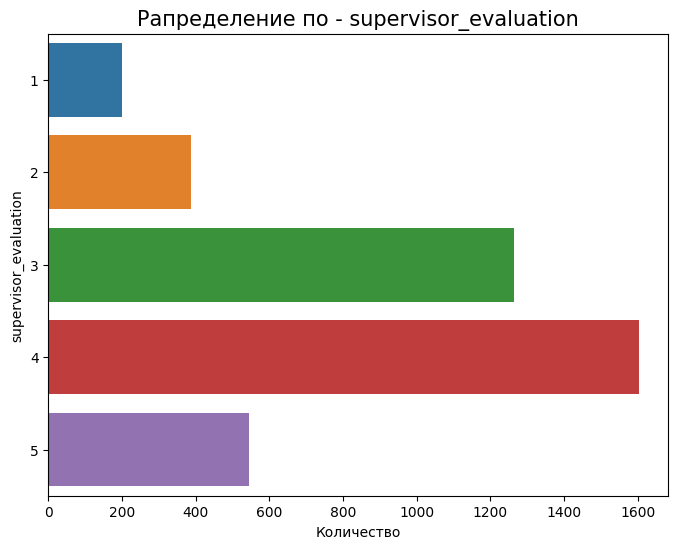

In [37]:
direct_diagram(train_job_satisfaction_rate, 'supervisor_evaluation')

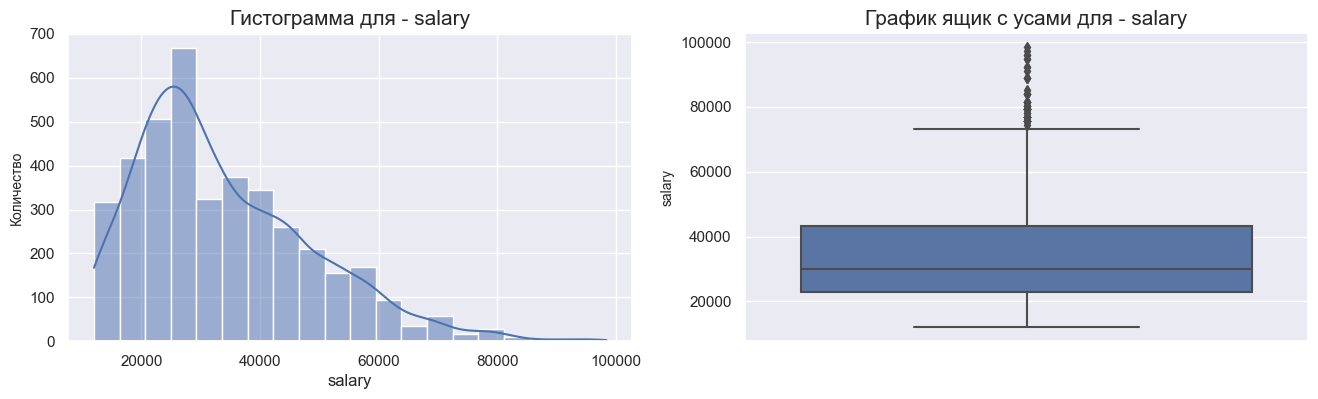

------------------------------------------------------------------------------------------------------------------------------


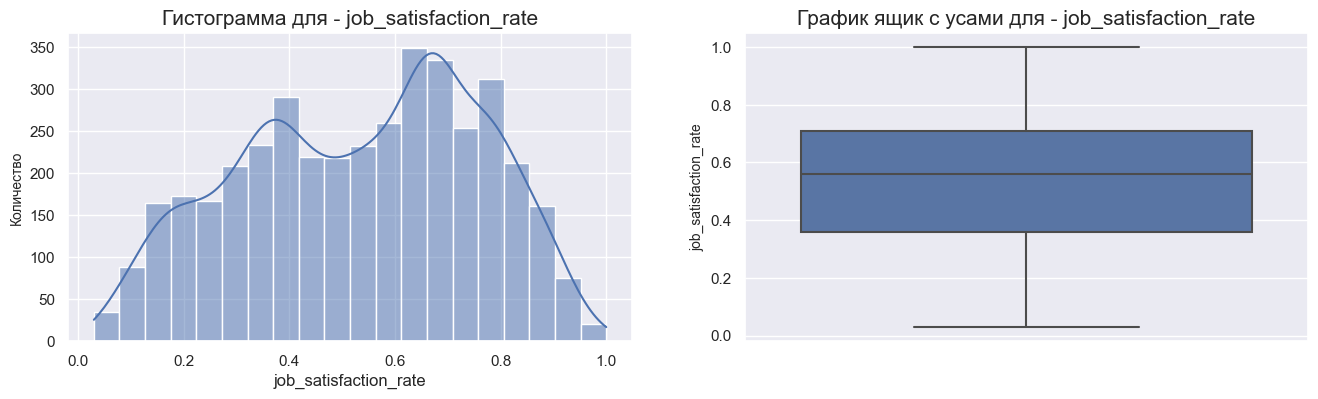

In [38]:
data_analysis(train_job_satisfaction_rate, 'salary')
print(line)
data_analysis(train_job_satisfaction_rate, 'job_satisfaction_rate')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Столбец 'supervisor_evaluation' - чаще всего сотрудники получают оценку от руководителя в размере 3 или 4 балов из 5.
<br>Столбец 'salary' - больше всего сотрудников получают зарплату от 20 до 30 тысяч в месяц. графи к усами показывает что есть подозрительные значения когда зарплата выше 70-75 тысяч. Если учесть что всего 9% сотрудников занимают высокую должность а сотрудников с зарплатой больше 60 тысяч не много то выглядит правдоподобно.
<br>Столбец 'job_satisfaction_rate' - больше всего оценка удовлетворённости сотрудника работой в компании у сотрудников составляет 6,7 или 4 бала. Средняя оценка 5.5 балов.
</div>

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Проводим ИАД для таблицы test_features.
</div>

In [39]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


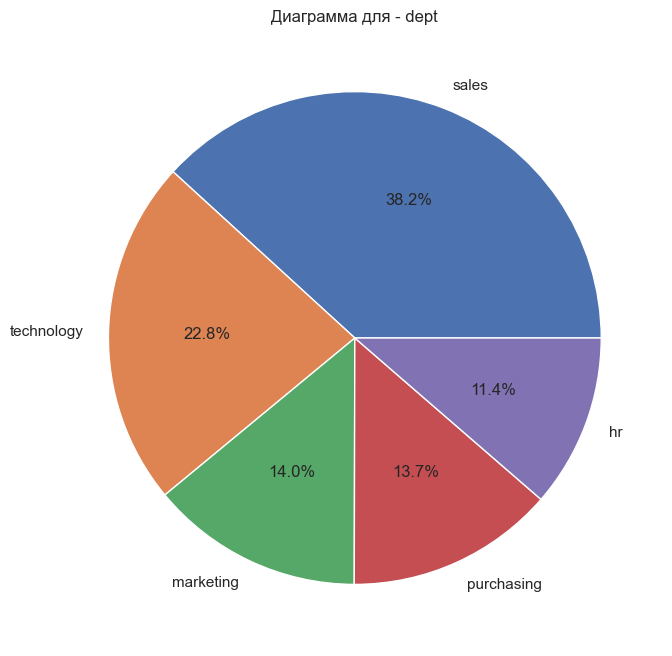

------------------------------------------------------------------------------------------------------------------------------


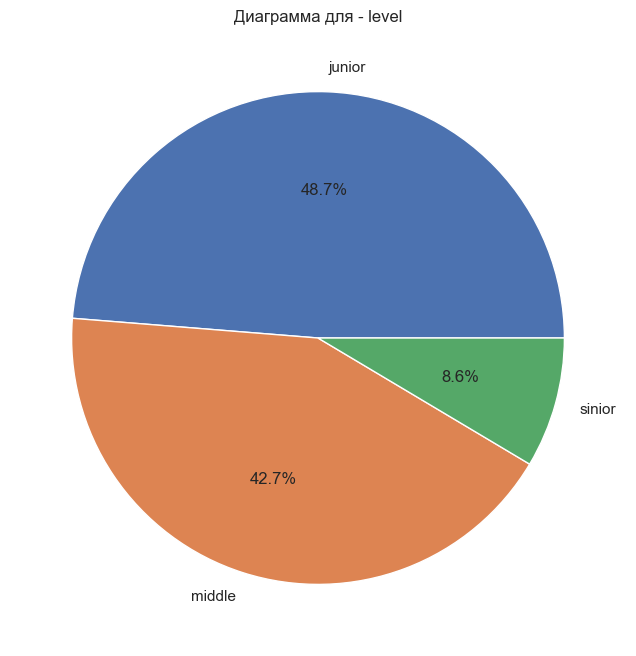

------------------------------------------------------------------------------------------------------------------------------


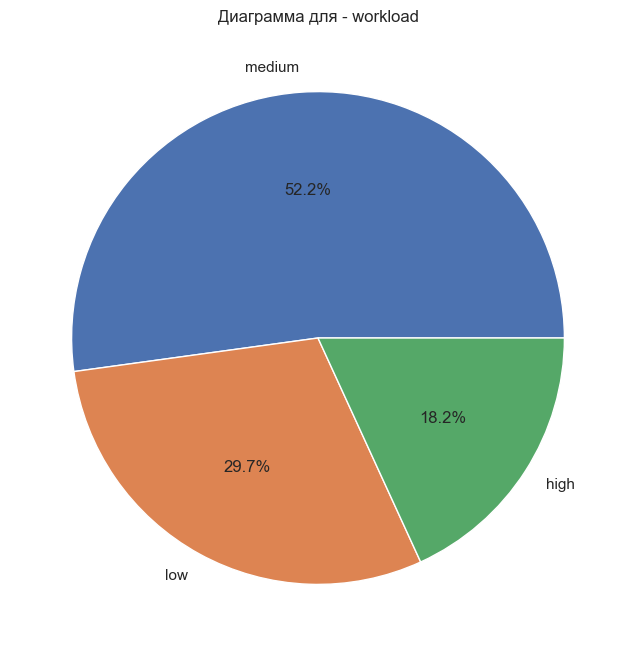

In [40]:
radial_diagram(test_features,'dept')
print(line)
radial_diagram(test_features,'level')
print(line)
radial_diagram(test_features,'workload')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Столбец 'dept' - 38% сотрудников работают на должностях занимающихся товарооборотом. Меньше всего сотрудников в отледе эйчаров - 11.4%
<br>Столбец 'level' - почти половина сотрудников 48.7% занимают младшие должности. И только 8.6% занимают высокие. 
<br>Столбец 'workload' - половина сотрудников 52.1% считают что у них высокая загруженость на работе.
</div>

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10], dtype=int64)

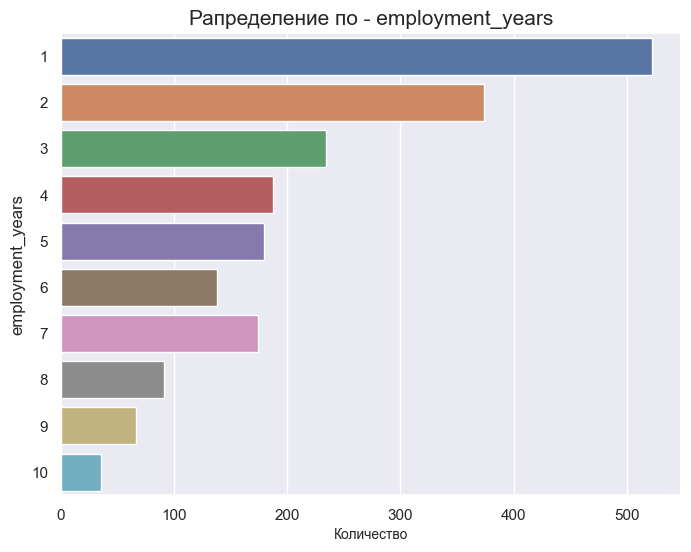

In [41]:
direct_diagram(test_features, 'employment_years')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Большая часть сотрудников раотает в компании 2 или 1 год. В среднем стаж работы сотрудников в компании 2.5 года.
</div>

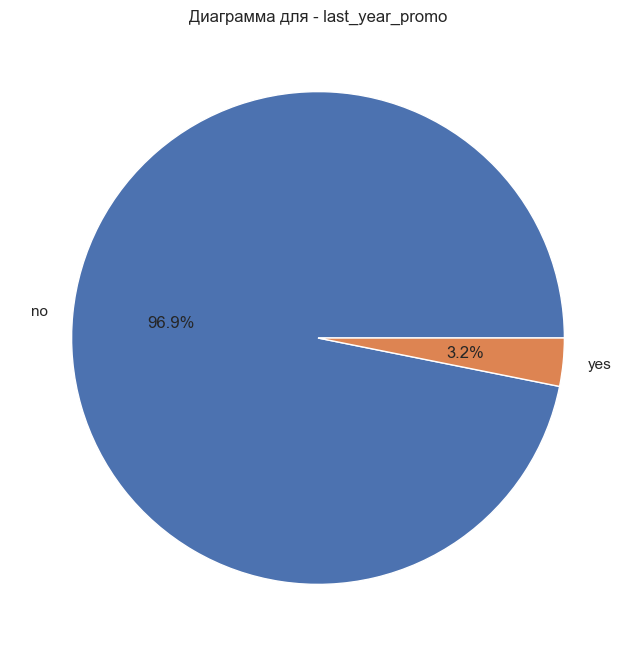

------------------------------------------------------------------------------------------------------------------------------


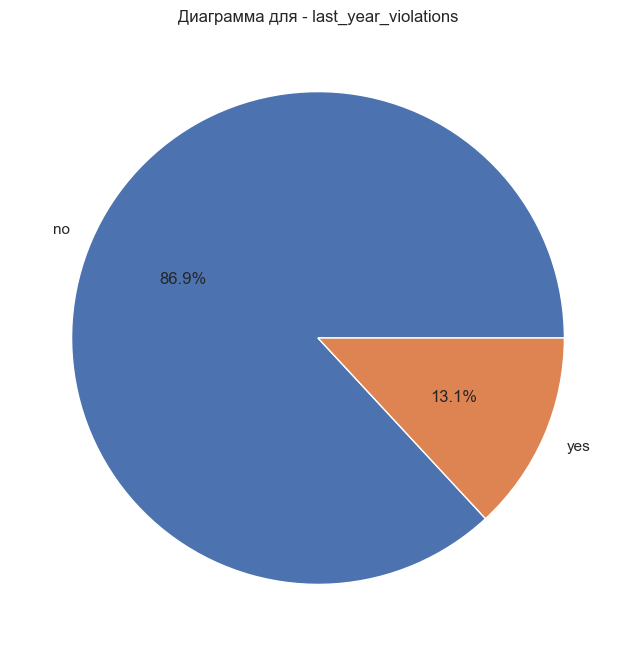

In [42]:
radial_diagram(test_features,'last_year_promo')
print(line)
radial_diagram(test_features,'last_year_violations')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Столбец 'last_year_promo' - только 3.2% сотрудников получили повышение за последний год.
<br>Столбец 'last_year_violations' -  только 13% сотрудников нарушали правила за последнй год.
</div>

array([5, 4, 3, 1, 2], dtype=int64)

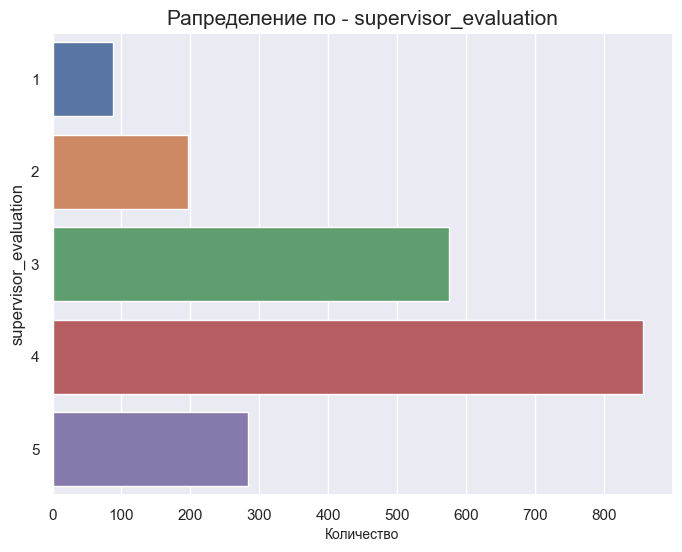

In [43]:
direct_diagram(test_features, 'supervisor_evaluation')

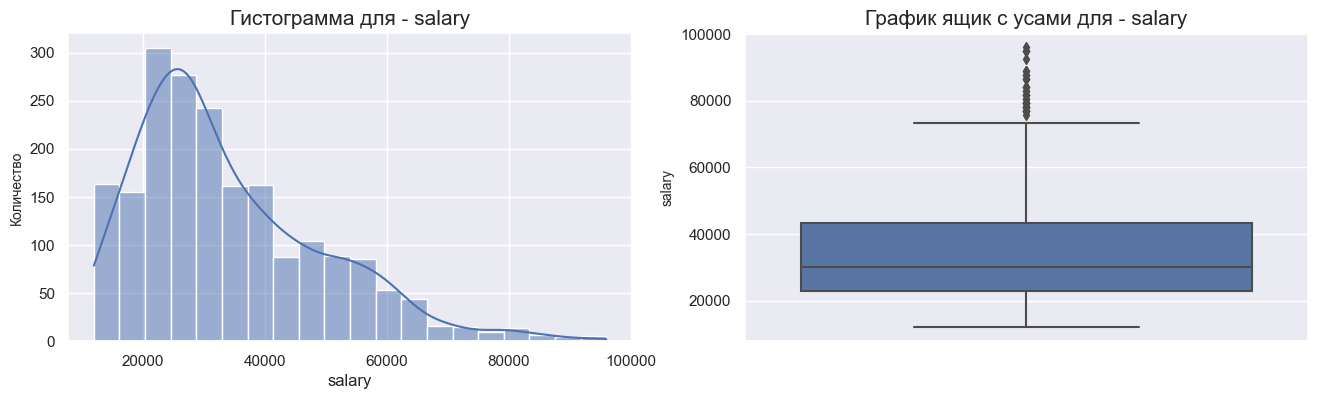

In [44]:
data_analysis(test_features, 'salary')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Столбец 'supervisor_evaluation' - чаще всего сотрудники получают оценку от руководителя в размере 4х балов из 5.
<br>Столбец 'salary' - больше всего сотрудников получают зарплату от 20 до 30 тысяч в месяц. графи к усами показывает что есть подозрительные значения когда зарплата выше 70-75 тысяч. Если учесть что всего 8.6% сотрудников занимают высокую должность а сотрудников с зарплатой больше 60 тысяч не много то выглядит правдоподобно.
</div>

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Проводим ИАД для таблицы test_target_job_satisfaction_rate.
</div>

In [45]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


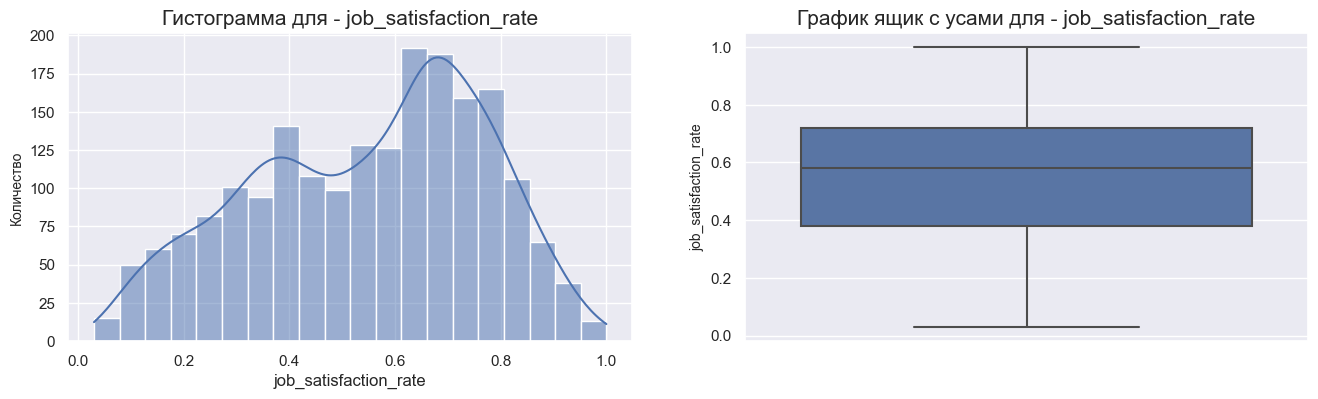

In [46]:
data_analysis(test_target_job_satisfaction_rate, 'job_satisfaction_rate')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Больше всего оценка удовлетворённости сотрудника работой в компании у сотрудников составляет 6,7 или 8 балов. Средняя оценка 5.8 балов.
</div>

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>Был проведен иследовательский анализданных 3х таблиц. В основном сотрудники компании являются начинающими специалистами которые не отработали ещё и 3х лет. Половина сотрудников чувствует высокую загруженость на работе а также повышения в компании бывают редко. Сотрудники компании имеют мало нарушений по работе при средней зарплате 25-30 тысяч. Руководство компании даёт сотрудникам среднюю оценку как и сами сотрудники дают среднюю оценку компании как работодателю.
</div>

##  Подготовка данных

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Так как при моделировании столбец id не нужен сделаем из него индекса. А так-же объеденим таблицы 'test_features' и 'test_target_job_satisfaction_rate' в таблицу 'test_features_and_satisfaction_rate'.
</div>

In [47]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')

test_features = test_features.set_index('id')

test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')

test_features_and_satisfaction_rate = df.merge(test_features, test_target_job_satisfaction_rate, on="id")
test_features_and_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


<div class="alert alert-info">
<b>Коментарий:</b>
<br>Проведем корреляционный анализ данных.
</div>

In [48]:
corr_matrix = train_job_satisfaction_rate.phik_matrix()
corr_matrix.round(2)

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.00,0.00,0.02,0.04,0.00,0.00,0.11,0.28,0.08
level,0.00,1.00,0.42,0.68,0.10,0.00,0.00,0.72,0.08
workload,0.02,0.42,1.00,0.18,0.06,0.00,0.04,0.79,0.06
employment_years,0.04,0.68,0.18,1.00,0.18,0.06,0.00,0.48,0.33
last_year_promo,0.00,0.10,0.06,0.18,1.00,0.00,0.01,0.22,0.19
last_year_violations,0.00,0.00,0.00,0.06,0.00,1.00,0.18,0.01,0.56
supervisor_evaluation,0.11,0.00,0.04,0.00,0.01,0.18,1.00,0.00,0.76
salary,0.28,0.72,0.79,0.48,0.22,0.01,0.00,1.00,0.17
job_satisfaction_rate,0.08,0.08,0.06,0.33,0.19,0.56,0.76,0.17,1.00


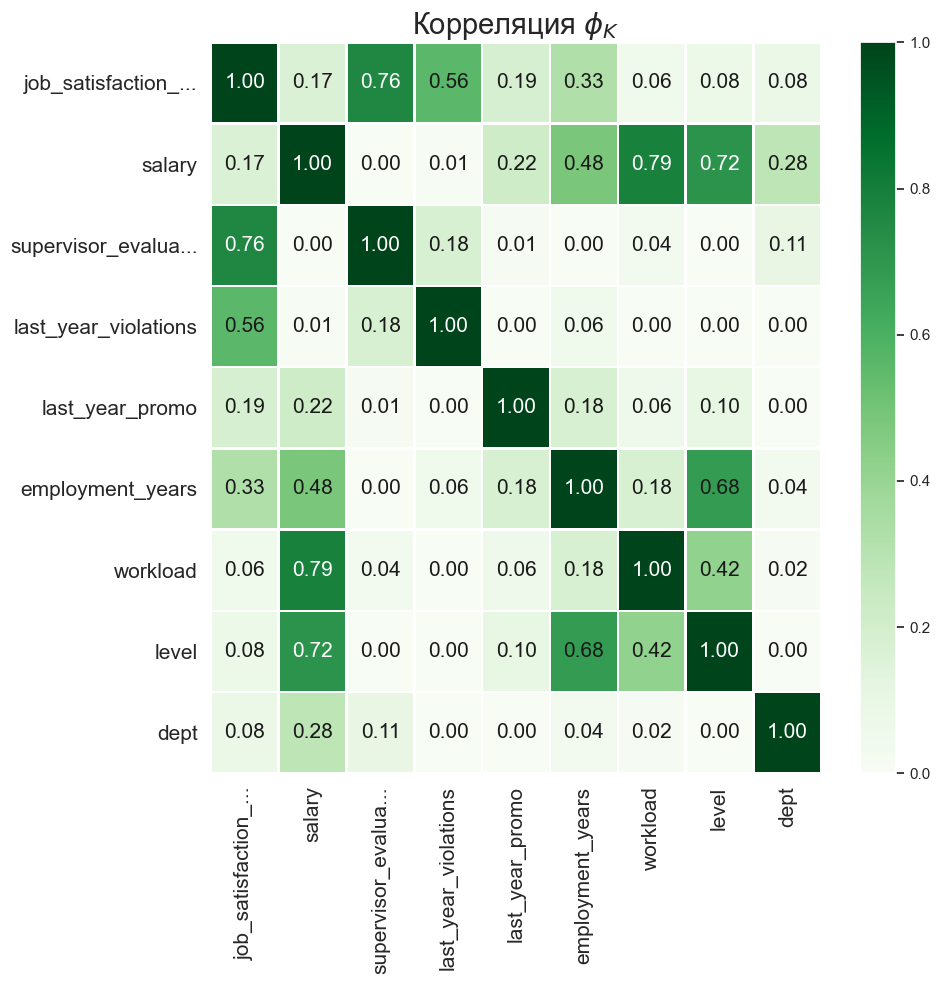

In [49]:
interval_cols = ['job_satisfaction_rate', 'salary']
phik_overview = train_job_satisfaction_rate.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=corr_matrix.columns,
    y_labels=corr_matrix.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Корреляция $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(10, 10)
)

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Хорошая корреляция видна междку такими признаками как:
<br>workload - salary
<br>level - salary
<br>supervisor_evaluation - job_satisfaction_rate
</div>

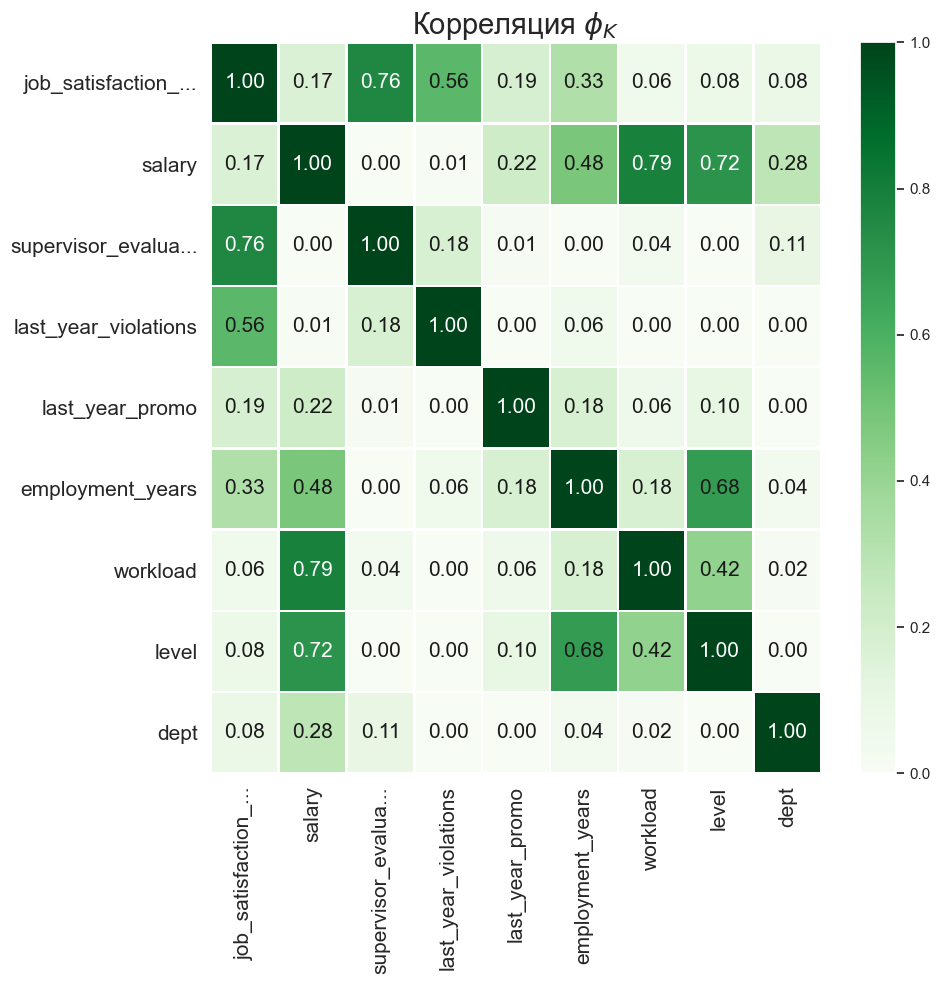

In [50]:
#Пример того что матрица не изменилась.
plot_correlation_matrix(
    corr_matrix.values,
    x_labels=corr_matrix.columns,
    y_labels=corr_matrix.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Корреляция $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(10, 10)
)

<AxesSubplot:xlabel='dept', ylabel='job_satisfaction_rate'>

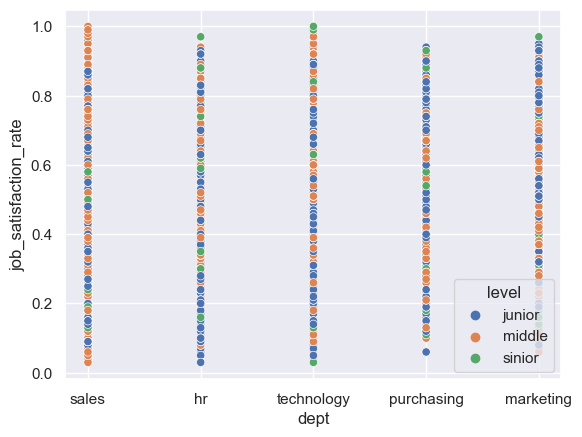

In [51]:
sns.scatterplot(data=train_job_satisfaction_rate,x="dept",y="job_satisfaction_rate", hue="level")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Ни один сотрудник из отделов 'hr', 'purchasing' и 'marketing' не был доволен работой на 100%. Сотрудники занимающие должность 'sinior'чаще остальны довольны своей работой, хотя бывает и исулючение.
</div>

<AxesSubplot:xlabel='level', ylabel='job_satisfaction_rate'>

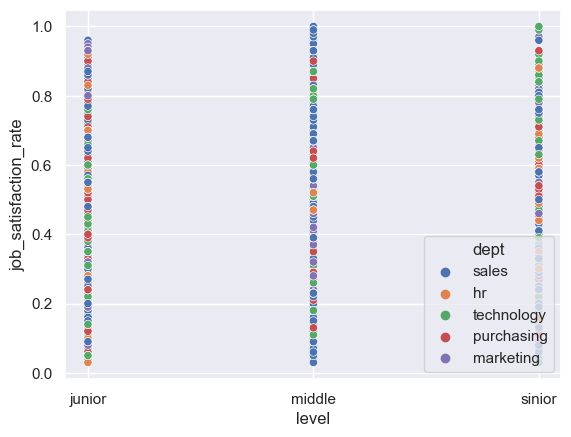

In [52]:
sns.scatterplot(data=train_job_satisfaction_rate,x="level",y="job_satisfaction_rate", hue="dept")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Рассмотрим должности по отношению к оценке ближе. Ни один 'junior' не поставил самый высокий бал компании. Нет выбивающегося отдела в оценке, как низкие так и высокие отделы расспределены равномерно по отделам. 
</div>

<AxesSubplot:xlabel='workload', ylabel='job_satisfaction_rate'>

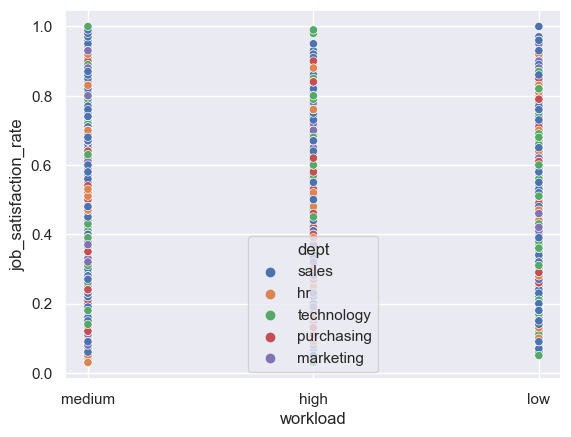

In [53]:
sns.scatterplot(data=train_job_satisfaction_rate,x="workload",y="job_satisfaction_rate", hue="dept")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Можно сказать что уровень загруженности мало влият на оценку качества удовлетворенности работой. Но видно как сотрудники отдела 'sales' загружены менее остальных отделов.
</div>

<AxesSubplot:xlabel='employment_years', ylabel='job_satisfaction_rate'>

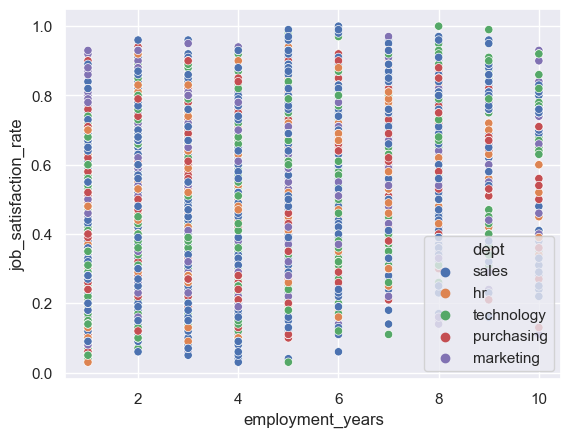

In [54]:
sns.scatterplot(data=train_job_satisfaction_rate,x="employment_years",y="job_satisfaction_rate", hue="dept")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Нет каких-то сотрудников или отделов которые сильнее других отличаются от остальных в оценке. Оуенка качества работодателя в отношении отработанх лет растет и падает чрез год. 
</div>

<AxesSubplot:xlabel='last_year_promo', ylabel='job_satisfaction_rate'>

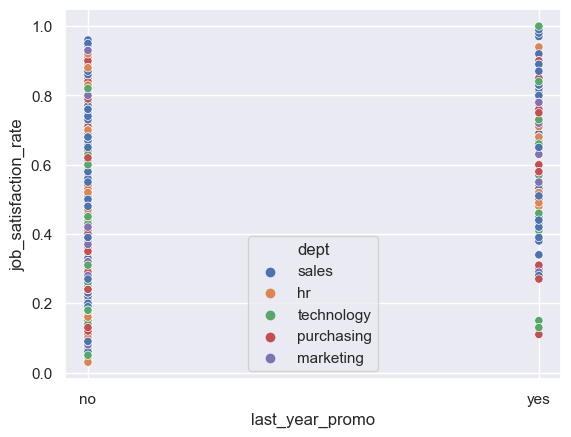

In [55]:
sns.scatterplot(data=train_job_satisfaction_rate,x="last_year_promo",y="job_satisfaction_rate", hue="dept")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Ни один сотрудник не у которого не было повышения за текущий год не поставил высокий бал в то время как ни один сотрудник у которого было повышение не поставил самый низкий бал. Особо выбивающихся отделов тоже нет. 
</div>

<AxesSubplot:xlabel='last_year_violations', ylabel='job_satisfaction_rate'>

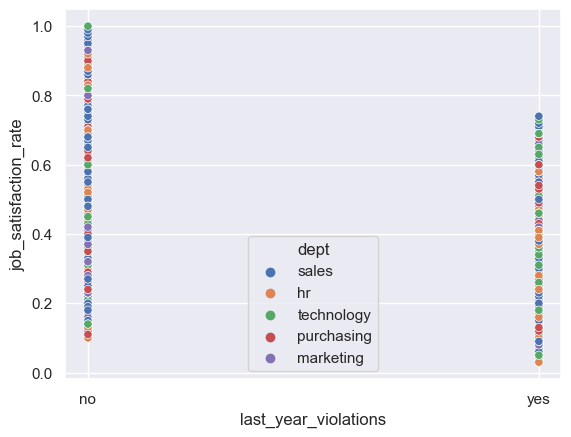

In [56]:
sns.scatterplot(data=train_job_satisfaction_rate,x="last_year_violations",y="job_satisfaction_rate", hue="dept")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Сотрудники которые нарушали трудовой договор не ставят оценок больше 0.8 баллов в то время как у сотрудники соблюдающие ТД нет критических замечаний к работодателю. 
</div>

<AxesSubplot:xlabel='supervisor_evaluation', ylabel='job_satisfaction_rate'>

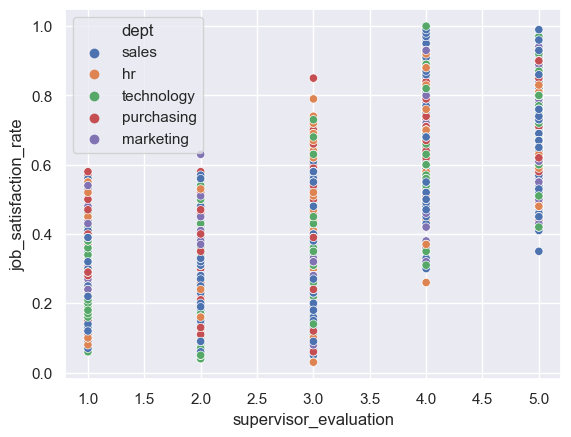

In [57]:
sns.scatterplot(data=train_job_satisfaction_rate,x="supervisor_evaluation",y="job_satisfaction_rate", hue="dept")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Видна хорошая взаимосвязь что чем выше работодатель даёт оценку сотруднику тем вышел сотрудник даёт оценку работодателю.
</div>

<AxesSubplot:xlabel='salary', ylabel='job_satisfaction_rate'>

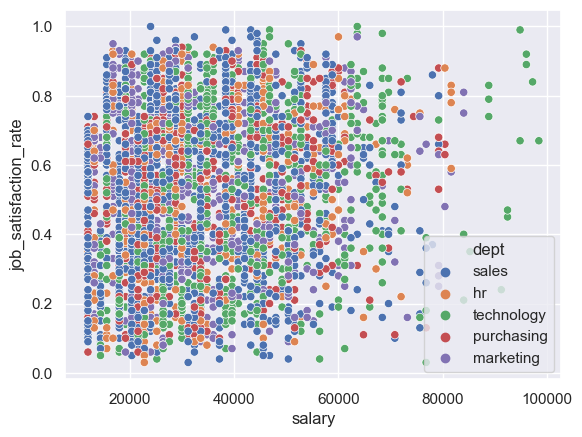

In [58]:
sns.scatterplot(data=train_job_satisfaction_rate,x="salary",y="job_satisfaction_rate", hue="dept")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Выглядит логично, чем выше зарплата тем выше удовлетворенность сотрудником компанией.
</div>

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создадим тестовые и тренировочные выборки. Так как для тестов нам представлен целый датасет, в качестве тестовой выборки будем использовать его.
</div>

In [59]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

X_test = test_features_and_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_test = test_features_and_satisfaction_rate['job_satisfaction_rate']

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создаём списки с названиями признаков
</div>

In [60]:
ohe_columns = ['dept', 'last_year_promo',
               'last_year_violations']

ord_columns = ['level','workload']

num_columns = ['employment_years','supervisor_evaluation',
              'salary']

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создаём пайплайны для подготовки признаков
</div>

In [61]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown = 'ignore', drop = 'first')
        )
    ]
)
ohe_pipe

Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [62]:
ord_pipe = Pipeline(
    [
        (
            'simple_impoter_ord_before',
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                ['junior','middle','sinior'],
                ['medium', 'high', 'low']],
                           handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        ('simple_imputer_ord_after',
         SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        )
    ]
)
ord_pipe

Pipeline(steps=[('simple_impoter_ord_before',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],
                                            ['medium', 'high', 'low']],
                                handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simple_imputer_ord_after',
                 SimpleImputer(strategy='most_frequent'))])

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создаём общий пайплайн для подготовки данных
</div>

In [63]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder = 'passthrough'
)
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simple_impoter_ord_before',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'sinior'],
                                                                             ['medium',
                                                                              'high',
                                                                              'low']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simple_imputer_ord_after',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('num', MinMaxScaler(),
                                 ['employment_years', 'supervisor_evaluation',
                                  'salary'])])

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Cоздаём итоговый пайплайн.
</div>

In [64]:
pipe_final= Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', LinearRegression(n_jobs = -1))])
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_impoter_ord_before',
                                                                   SimpleImpute...
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['medium',
                                                                                               'high',
                                                                                               'low']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simple_imputer_ord_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models', LinearRegression(n_jobs=-1))])

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>Были объеденены таблицы 'test_features' и 'test_target_job_satisfaction_rate' в таблицу 'test_features_and_satisfaction_rate
<br>Была проведена корреляция данных где видна хорошее взаимоотношение такеих данных:
<br>workload - salary
<br>level - salary
<br>supervisor_evaluation - job_satisfaction_rate
<br>Так-же был проведен кореляционный анализ отдельных признаков, где было выявленно что на оценку от сотрудника хорошо влияют ткие факты как:
<br>'dept'
<br>'employment_years'
<br>'last_year_promo'
<br>'last_year_violations'
<br>'supervisor_evaluation'
<br>'salary'
<br>Был создан общий пайплайн с подготовленными признаками и итоговый пайплайн с моделью 'LinearRegression'.
</div>

## Обучение моделей

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Подготовка данных и модель
</div>

In [65]:
param_grid  = [
    { 'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     {
        'models': [KNeighborsRegressor()],  
        'models__n_neighbors': range(3, 10),  
        'models__weights': ['uniform', 'distance'],  
        'models__algorithm': ['auto', 'brute'],  
        'models__p': [1, 2], 
        'models__metric': ['euclidean', 'manhattan'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]
param_grid    

[{'models': [DecisionTreeRegressor(random_state=42)],
  'models__max_depth': range(2, 5),
  'models__max_features': range(2, 5),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [KNeighborsRegressor()],
  'models__n_neighbors': range(3, 10),
  'models__weights': ['uniform', 'distance'],
  'models__algorithm': ['auto', 'brute'],
  'models__p': [1, 2],
  'models__metric': ['euclidean', 'manhattan'],
  'preprocessor__num': [StandardScaler(),
   MinMaxScaler(),
   RobustScaler(),
   'passthrough']},
 {'models': [LinearRegression(n_jobs=-1)],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

<div class="alert alert-info">
<b>Коментарий:</b>
<br> Создаем метрику SMAPE. И применяем её на модели.
</div>

In [66]:
def SMAPE(y_true, y_pred):
    n = len(y_true)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    summ = np.sum(numerator / denominator)
    smape_final = summ * (100 / n)
    return smape_final

smape_scorer = make_scorer(SMAPE, greater_is_better=False)

In [67]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid , 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1)
randomized_search

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'models__n_neighbors': range(3, 10),
                                         'models__p': [1, 2],
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression(n_jobs=-1)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(SMAPE, greater_is_better=False, response_method='predict'))

In [68]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'models__n_neighbors': range(3, 10),
                                         'models__p': [1, 2],
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression(n_jobs=-1)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(SMAPE, greater_is_better=False, response_method='predict'))

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Выводим лучшую модель и её метрику.
</div>

In [69]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(line)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_impoter_ord_before',
                                  

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Лучшая модель и её параметры - KNeighborsRegressor(metric='manhattan', weights='distance')
<br>Метр ика лучшей модели - 15.3
</div>

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Смотрим метрику SMAPE.
</div>

In [70]:
y_test_pred = randomized_search.best_estimator_.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {SMAPE(y_test, y_test_pred)}')

Метрика SMAPE на тестовой выборке: 14.138289112271423


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Метрика SMAPE - 14.1, так как желательно что-бы она была меньше 15 то такой результат нас устраивает. 
</div>

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Сделаем предсказание для тестового датафрейма.
</div>

In [71]:
test_features_and_satisfaction_rate['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(X_test)
test_features_and_satisfaction_rate.drop('job_satisfaction_rate', axis=1, inplace=True)
test_features_and_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.866667
686555,hr,junior,medium,1,no,no,4,30000,0.670000
467458,sales,middle,low,5,no,no,4,19200,0.648000
418655,sales,middle,low,6,no,no,4,19200,0.655000
789145,hr,middle,medium,5,no,no,5,40800,0.760000


<div class="alert alert-info">
<b>Коментарий:</b>
<br>Сделаем предсказание для тестового датафрейма.
</div>

<div class="alert alert-info">
<b>Вывод задания 1:</b>
<br>Были созданы 3 таблицы - 
<br>1. train_job_satisfaction_rate - 4000 строк и 10 столбцов.
<br>2. test_features - 2000 строк и 9 столбцов.
<br>3. test_target_job_satisfaction_rate - 2000 строк и 2 столбца.
<br>В таблицах train_job_satisfaction_rate и test_features были обнаружены пропуски. Во всех трех таблицах не было обнаруженно явных или не явных дубликатов.
<br>Был проведен Анализ данных.п о которому можно сделать вывод что в основном сотрудники компании являются начинающими специалистами которые не отработали ещё и 3х лет. Половина сотрудников чувствует высокую загруженость на работе а также повышения в компании бывают редко. Сотрудники компании имеют мало нарушений по работе при средней зарплате 25-30 тысяч. Руководство компании даёт сотрудникам среднюю оценку как и сами сотрудники дают среднюю оценку компании как работодателю.  
<br>Так-же был проведен корреляционный анализ данных где видна хорошее взаимоотношение такеих данных:
<br>workload - salary
<br>level - salary
<br>supervisor_evaluation - job_satisfaction_rate
<br>Так-же был проведен кореляционный анализ отдельных признаков, где было выявленно что на оценку от сотрудника хорошо влияют ткие факты как:
<br>'dept'
<br>'employment_years'
<br>'last_year_promo'
<br>'last_year_violations'
<br>'supervisor_evaluation'
<br>'salary'
<br>Был создан пайплайн и выведена лучшая модель и её параметры - KNeighborsRegressor(metric='manhattan', weights='distance'). Модель была посчитана на метрике SMAPE которая показала - 14.1 так-как задача стояла показать метрику меньше 15 то это приемлемый результат. 
<br>В таблице test_features_and_satisfaction_rate была создана колонка 'job_satisfaction_rate_pred' с предсказанными моделью данными.
</div>

<div class="alert alert-info">
<b>Задача 2: предсказание увольнения сотрудника из компании</b>
</div>

<div class="alert alert-info">
<b>Задача:</b>
<br>Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
<br>
<b>Данные:</b>
<br>Дано 3 таблицы 
<br>1. Файл train_job_satisfaction_rate.csv
<br>2. Файл test_features.csv
<br>3. Файл test_target_job_satisfaction_rate.csv
<br>Все 3 файла содержат одинаковые столбцы:
<br>id — уникальный идентификатор сотрудника;
<br>dept — отдел, в котором работает сотрудник;
<br>level — уровень занимаемой должности;
<br>workload — уровень загруженности сотрудника;
<br>employment_years — длительность работы в компании (в годах);
<br>last_year_promo — показывает, было ли повышение за последний год;
<br>last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
<br>supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
<br>salary — ежемесячная зарплата сотрудника;
<br>quit — увольнение сотрудника из компании, целевой признак.

## Загрузка данных

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Открываем файл - train_quit.csv, сохраняем его в переменную - train_quit и смотрим по нему информацию.
</div>

In [72]:
train_quit = df.read_csv('train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [73]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Таблица содержит 4000 строк и 10 столбцов. Типы столбцов соответствуют их данным. Пропусков нет. 
</div>

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Так как таблица test_features.csv таже что была в первом задании её трогать не будем.
</div>

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Открываем файл - test_target_quit.csv, сохраняем его в переменную - test_target_quit и смотрим по нему информацию. 
</div>

In [74]:
test_target_quit = df.read_csv('test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [75]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Таблица содержит 2000 строк и 2 столбца. Типы столбцов соответствуют их данным. Пропусков нет. 
</div>

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>Было создано 2 таблицы:
<br>1. train_quit - 4000 строк и 10 столбцов.
<br>2. test_target_quit - 2000 строк и 2 столбца.
<br>Пропуски в таблицах нет. 
</div>

##  Предобработка данных

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Проводим переработку данных таблицы 'train_quit'.
</div>

In [76]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [77]:
train_quit.duplicated().sum()

0

In [78]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [79]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [80]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [81]:
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [82]:
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [83]:
train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Явные и неявные дубликаты отсутвуют.
</div>

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Проводим переработку данных таблицы 'test_target_quit'.
</div>

In [84]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [85]:
train_quit.duplicated().sum()

0

In [86]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Явные и неявные дубликаты отсутвуют.
</div>

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>В таблицах 'train_quit' и 'test_target_quit' отсутстыуют пропуски и дубликаты.
</div>

## Исследовательский анализ данных

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Проведем исследовательский анализ данных для выявления портрета уволившегося сотрудника.
</div>

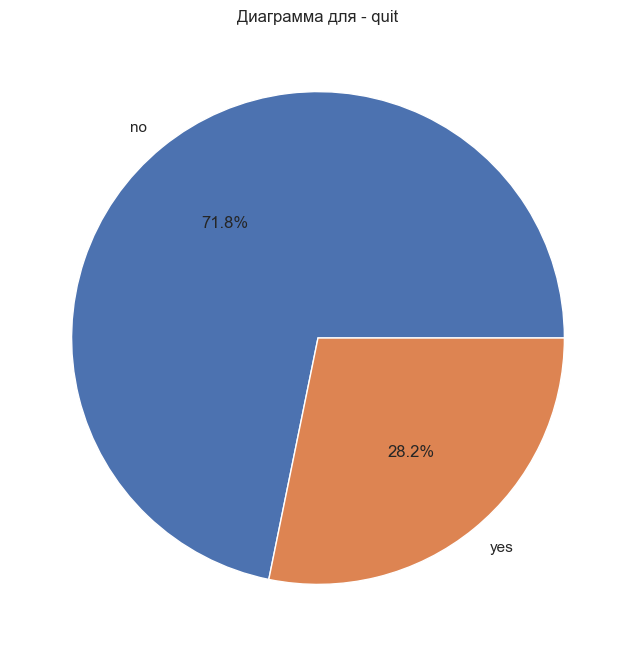

In [87]:
radial_diagram(train_quit,'quit')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Для начала мы видим что уволилось 28% сотрудников. Так-как интересны только те кто уволился, будем проводить дальнейший анализ на них.
</div>

In [88]:
train_quit_quit = train_quit[train_quit['quit'] == 'yes']

test_target_quit = test_target_quit.set_index('id')

test_features_and_satisfaction_rate_and_test_target_quit = df.merge(test_features_and_satisfaction_rate, test_target_quit, on="id")

test_features_and_satisfaction_rate_and_test_target_quit_quit = test_features_and_satisfaction_rate_and_test_target_quit[test_features_and_satisfaction_rate_and_test_target_quit['quit'] == 'yes']

array(['sales', 'technology', 'marketing', 'purchasing', 'hr'],
      dtype=object)

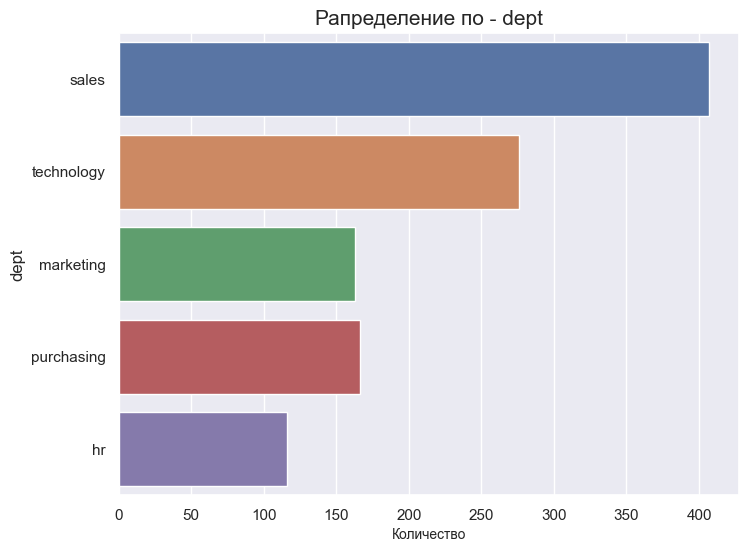

In [89]:
direct_diagram(train_quit_quit, 'dept')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Чаще всего сотрудники увольняются из отдела 'sales', что логично так-как исходя из прошлых результатов в этом отделе работает больше всего сотрудников.
</div>

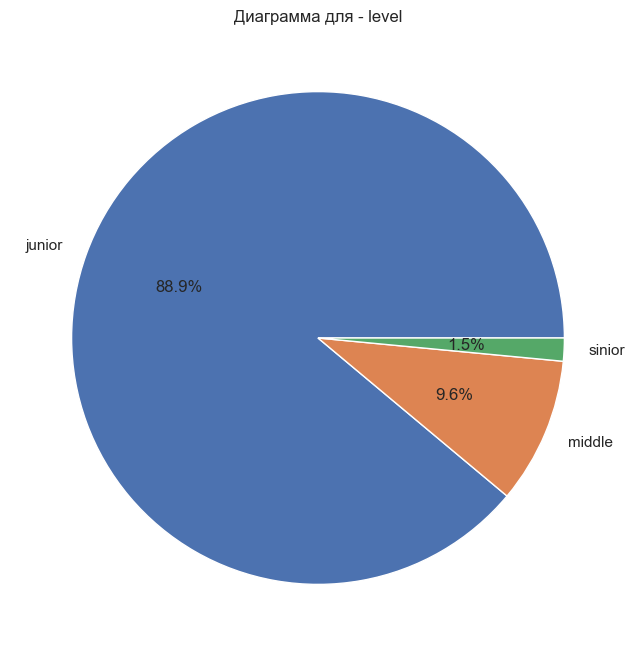

------------------------------------------------------------------------------------------------------------------------------


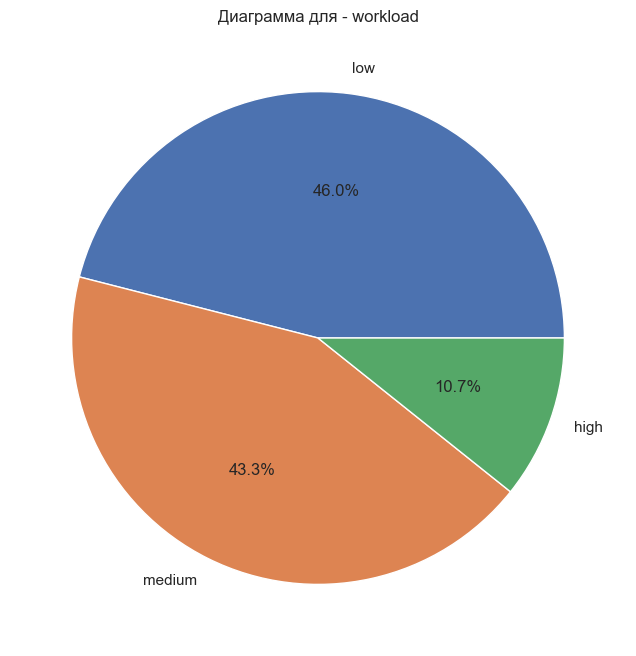

In [90]:
radial_diagram(train_quit_quit,'level')
print(line)
radial_diagram(train_quit_quit,'workload')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Чаще всего сотрудники увольняются ещё будучи джунами. А так-же с низкой и средней загрузкой.
</div>

array([ 2,  1,  3, 10,  5,  4,  6,  8,  7,  9], dtype=int64)

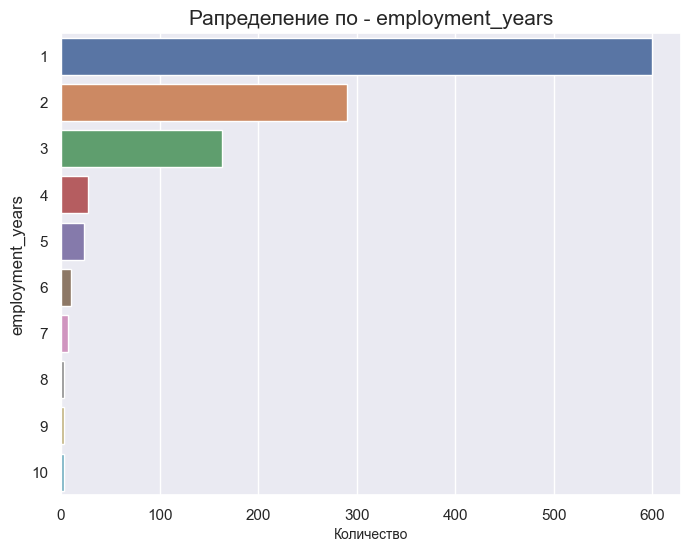

In [91]:
direct_diagram(train_quit_quit, 'employment_years')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>В основном уволившиеся сотрудники работают в компании не больше года.
</div>

array(['no', 'yes'], dtype=object)

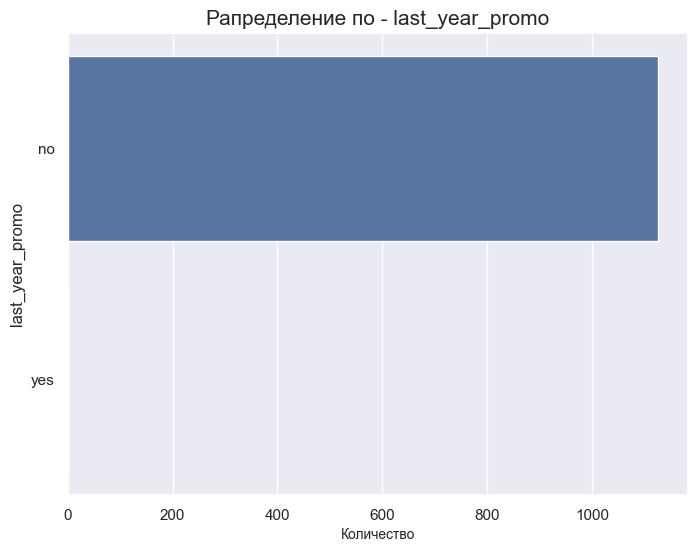

In [92]:
direct_diagram(train_quit_quit, 'last_year_promo')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Можно сказать что 100% уволившихся не получали повышения, что выглядит правдиво так-как многие не проработали в компании и двух лет.
</div>

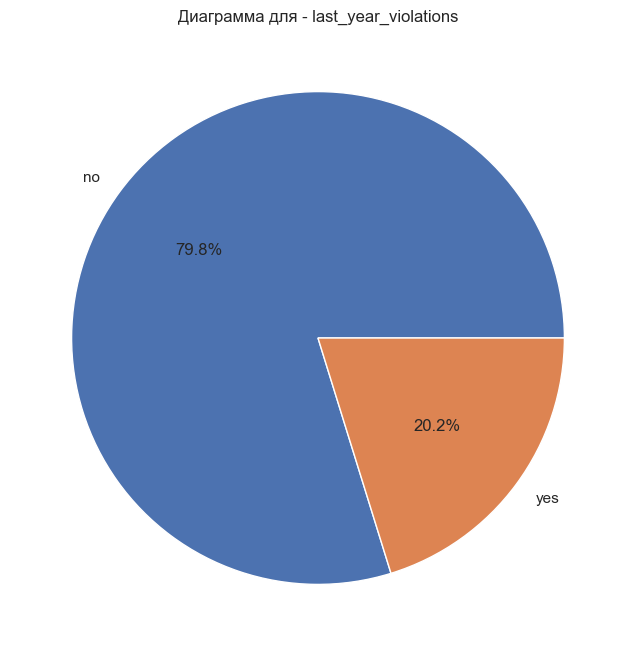

In [93]:
radial_diagram(train_quit_quit,'last_year_violations')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>А вот всего 20% уволившихся нарушали ТД.
</div>

array([3, 4, 5, 1, 2], dtype=int64)

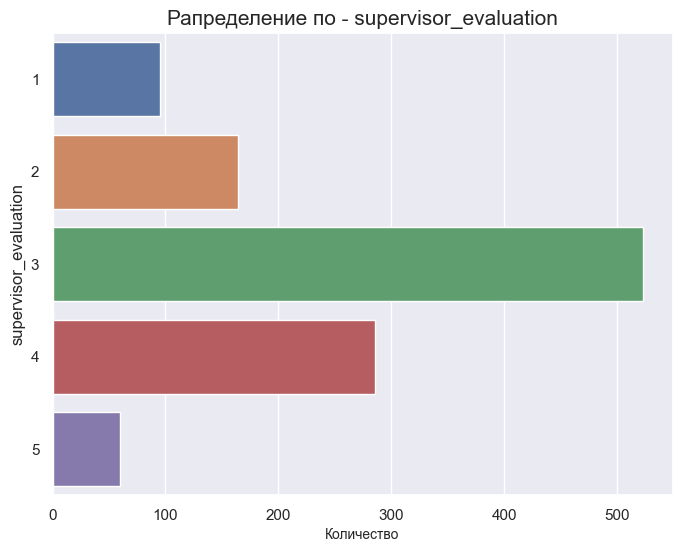

In [94]:
direct_diagram(train_quit_quit, 'supervisor_evaluation')

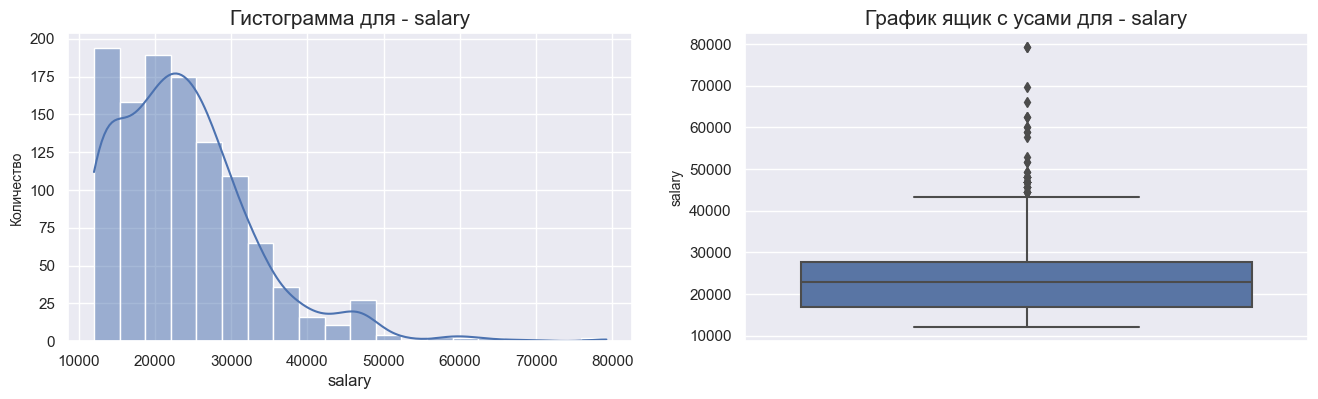

In [95]:
data_analysis(train_quit_quit, 'salary')

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Чаще всего уволившиеся сотрудники получают оценку от работодателя в 3 бала, и получают зарплату не больше 30000.
</div>

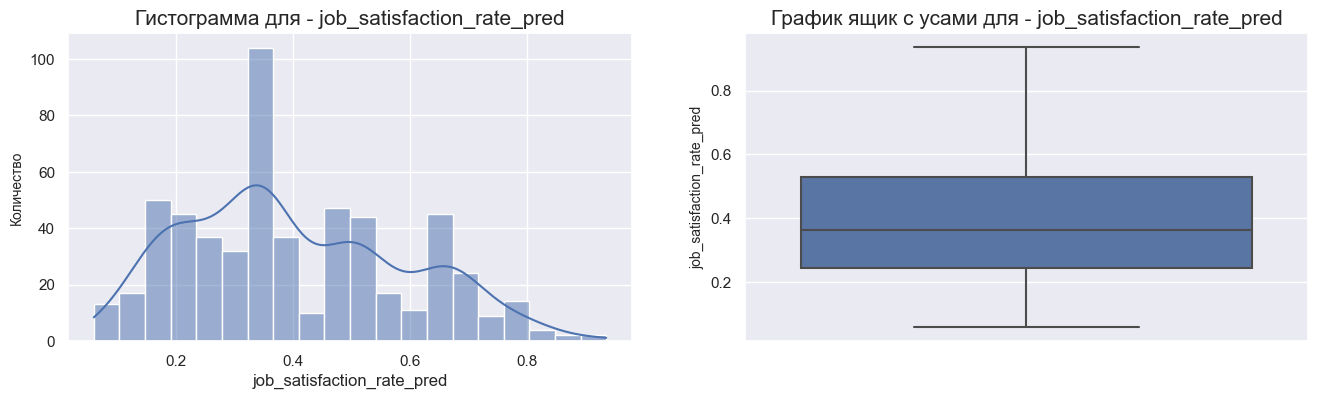

In [96]:
data_analysis(test_features_and_satisfaction_rate_and_test_target_quit_quit, 'job_satisfaction_rate_pred')

In [97]:
test_features_and_satisfaction_rate_and_test_target_quit_not_quit = test_features_and_satisfaction_rate_and_test_target_quit[test_features_and_satisfaction_rate_and_test_target_quit['quit'] == 'no']

Text(0.5, 0, 'Оценка')

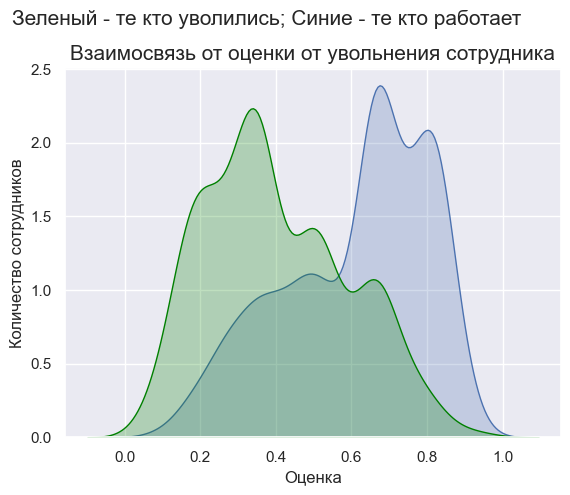

In [98]:
sns.kdeplot(test_features_and_satisfaction_rate_and_test_target_quit_not_quit['job_satisfaction_rate_pred'], shade = True)
sns.kdeplot(test_features_and_satisfaction_rate_and_test_target_quit_quit['job_satisfaction_rate_pred'], shade = True , color = "Green")
pd.text(-0.299,2.8,'Зеленый - те кто уволились; Синие - те кто работает', fontsize=15)
pd.title('Взаимосвязь от оценки от увольнения сотрудника', fontsize=15)
pd.ylabel("Количество сотрудников")
pd.xlabel("Оценка")

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Уволившиеся сотрудники почти не ставиили оценок больше 0.8 а средняя оценка от них находится в районе 0.4. Так-же видно что оценка различие между уволившимися сотрудниками и теми кто работает отличается прмиерно на 0.5, так-жетам где у работающих сотрудников виден резкий рост оценки после 0.5 балов в то врея как у уволившихся в этой отметке оценка резко падает.
</div>

In [99]:
def fraction_quit(datas,uniques):
    f = train_quit[train_quit['dept'] == 'sales']
    t = f[f['quit'] == 'yes']
    t = t['quit']
    t = t.count().sum()
    p = f['quit']
    p = p.count().sum()
    fraction = (t/p)*100 
    return(f'Процент уволившихся сотрудников из отдела {uniques} - {fraction.round(2)}')

In [100]:
print(fraction_quit(train_quit,'sales'))
print(line)
print(fraction_quit(train_quit,'technology'))
print(line)
print(fraction_quit(train_quit,'marketing'))
print(line)
print(fraction_quit(train_quit,'purchasing'))
print(line)
print(fraction_quit(train_quit,'hr'))

Процент уволившихся сотрудников из отдела sales - 28.3
------------------------------------------------------------------------------------------------------------------------------
Процент уволившихся сотрудников из отдела technology - 28.3
------------------------------------------------------------------------------------------------------------------------------
Процент уволившихся сотрудников из отдела marketing - 28.3
------------------------------------------------------------------------------------------------------------------------------
Процент уволившихся сотрудников из отдела purchasing - 28.3
------------------------------------------------------------------------------------------------------------------------------
Процент уволившихся сотрудников из отдела hr - 28.3


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Процент уволившихся сотрудников во всех отделах одинаковый 28.3%
</div>

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>Был проведен исследовательский анализ данных уволившихся сотрудников. Портрет уволившегося сотрудника выглядит следующим образом - такой сотрудник в основном работал в отделе 'sales' и был джуном с не самой высокой нагрузкой, он отработал в компании меньше 3х лет без повышений а так-же не с малой вероятностью нарушал трудовой договор. Такой сотрудник получал с высокой вероятностью не больше 30000 рублей а так-же не был по мнению работодателя средним сотрудником, свою жеоценку работодателю он ставил меньше 5 балов из 10 но все-же не давал высоких оценок больше 8. Так-же видно что оценка различие между уволившимися сотрудниками и теми кто работает отличается прмиерно на 0.5, так-жетам где у работающих сотрудников виден резкий рост оценки после 0.5 балов в то врея как у уволившихся в этой отметке оценка резко падает. Процент уволившихся сотрудников во всех отделах одинаковый 28.3%
</div>

## Добавление нового входного признака

<div class="alert alert-info">
<b>Комментарий:</b>
<br>Добавим предсказание в таблицу 'train_quit'.
</div>

In [101]:
train_quit['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(X_train)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.500
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.760
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.140
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.370
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.178


## Подготовка данных

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Столбец 'id' таблиц train_quit в индекс.
</div>

In [102]:
train_quit = train_quit.set_index('id')

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Проведем кореляционный анализ данных.
</div>

In [103]:
corr_matrix_new = train_quit.phik_matrix()
corr_matrix_new.round(2)

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
dept,1.00,0.00,0.00,0.00,0.00,0.04,0.04,0.28,0.00,0.00
level,0.00,1.00,0.48,0.69,0.11,0.00,0.01,0.75,0.31,0.02
workload,0.00,0.48,1.00,0.21,0.04,0.01,0.00,0.79,0.13,0.03
employment_years,0.00,0.69,0.21,1.00,0.16,0.00,0.00,0.49,0.66,0.04
last_year_promo,0.00,0.11,0.04,0.16,1.00,0.00,0.03,0.22,0.16,0.00
last_year_violations,0.04,0.00,0.01,0.00,0.00,1.00,0.18,0.09,0.19,0.01
supervisor_evaluation,0.04,0.01,0.00,0.00,0.03,0.18,1.00,0.06,0.25,0.00
salary,0.28,0.75,0.79,0.49,0.22,0.09,0.06,1.00,0.56,0.05
quit,0.00,0.31,0.13,0.66,0.16,0.19,0.25,0.56,1.00,0.00
job_satisfaction_rate_pred,0.00,0.02,0.03,0.04,0.00,0.01,0.00,0.05,0.00,1.00


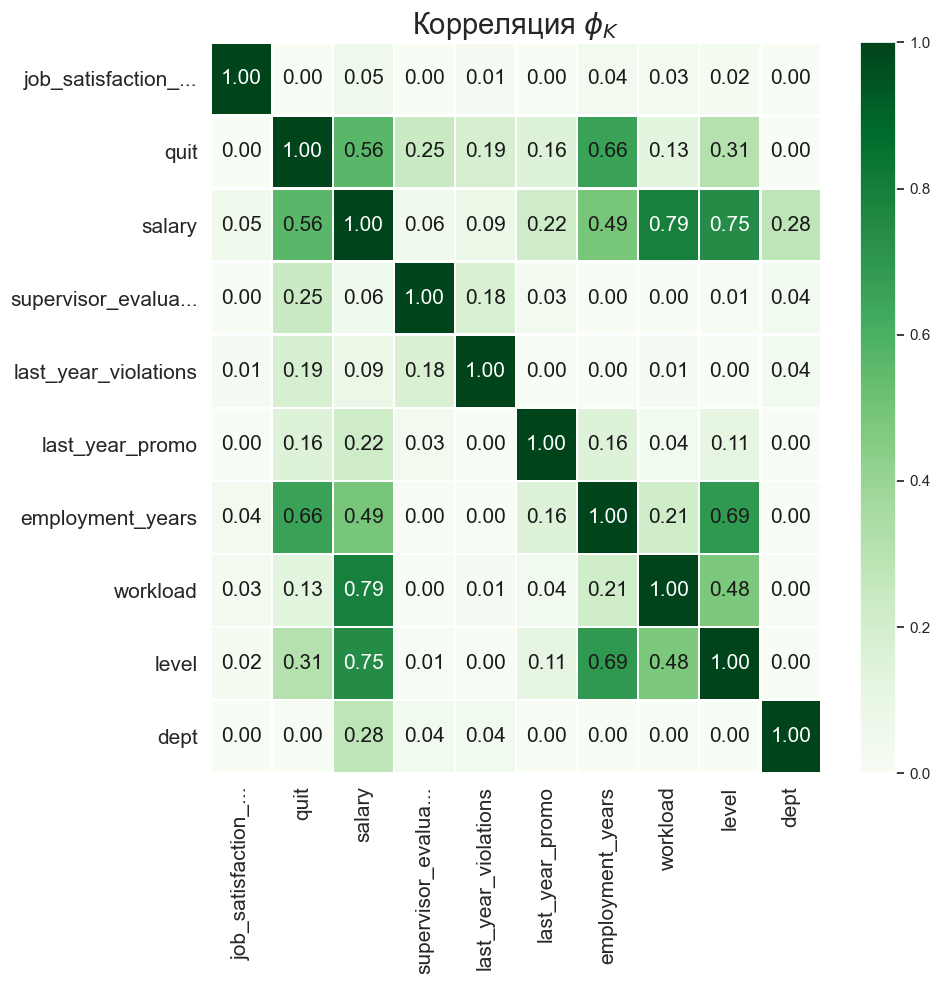

In [104]:
plot_correlation_matrix(
    corr_matrix_new.values,
    x_labels=corr_matrix_new.columns,
    y_labels=corr_matrix_new.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Корреляция $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(10, 10)
)

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Хорошая корреляция видна междку такими признаками как:
<br>workload - salary
<br>level - salary
<br>salary - quit
<br>employment_years - level
</div>

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создадим тестовые и тренировочные выборки. Так как для тестов нам представлен целый датасет, в качестве тестовой выборки будем использовать его.
</div>

In [105]:
X_train_quit = train_quit.drop(['quit'], axis=1)
y_train_quit = train_quit['quit']

X_test_quit = test_features_and_satisfaction_rate_and_test_target_quit.drop(['quit'], axis=1)
y_test_quit = test_features_and_satisfaction_rate_and_test_target_quit['quit']

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создаём списки с названиями признаков
</div>

In [106]:
ohe_columns = ['dept', 'last_year_promo',
               'last_year_violations']

ord_columns = ['level','workload']

num_columns = ['employment_years','supervisor_evaluation',
              'salary','job_satisfaction_rate_pred']

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создаём пайплайны для подготовки признаков
</div>

In [107]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown = 'error',drop = 'first')
        )
    ]
)
ohe_pipe

Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first'))])

In [108]:
ord_pipe = Pipeline(
    [
        (
            'simple_impoter_ord_before',
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                ['junior','middle','sinior'],
                ['medium', 'high', 'low']],
                           handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        ('simple_imputer_ord_after',
         SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        )
    ]
)
ord_pipe

Pipeline(steps=[('simple_impoter_ord_before',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],
                                            ['medium', 'high', 'low']],
                                handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simple_imputer_ord_after',
                 SimpleImputer(strategy='most_frequent'))])

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Создаём общий пайплайн для подготовки данных
</div>

In [109]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder = 'passthrough'
)
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simple_impoter_ord_before',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'sinior'],
                                                                             ['medium',
                                                                              'high',
                                                                              'low']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simple_imputer_ord_after',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('num', MinMaxScaler(),
                                 ['employment_years', 'supervisor_evaluation',
                                  'salary', 'job_satisfaction_rate_pred'])])

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Cоздаём итоговый пайплайн.
</div>

In [110]:
pipe_final= Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_impoter_ord_before',
                                                                   SimpleImputer(strategy='most_frequen...
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['medium',
                                                                                               'high',
                                                                                               'low']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simple_imputer_ord_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate_pred'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

<div class="alert alert-info">
<b>Вывод главы:</b>
<br>Были объеденены таблицы 'test_features_and_satisfaction_rate' и 'test_target_quit' в таблицу 'test_features_and_satisfaction_rate_and_test_target_quit
<br>Была проведена корреляция данных где видна хорошее взаимоотношение такеих данных:
<br>workload - salary
<br>level - salary
<br>salary - quit
<br>employment_years - level
<br>Был создан общий пайплайн с подготовленными признаками и итоговый пайплайн с моделью 'DecisionTreeClassifier'.
</div>

## Обучение моделей

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Подготовка данных и модель
</div>

In [111]:
param_grid = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 7),
     'models__max_features': range(2,7),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}, 
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,7),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    {'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
     'models__C': range(1,7),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  },
    {'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability= True)],
     'models__degree': range(2, 7),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]
param_grid

[{'models': [DecisionTreeClassifier(random_state=42)],
  'models__max_depth': range(2, 7),
  'models__max_features': range(2, 7),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [KNeighborsClassifier()],
  'models__n_neighbors': range(2, 7),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [LogisticRegression(penalty='l1', random_state=42, solver='liblinear')],
  'models__C': range(1, 7),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [SVC(kernel='poly', probability=True, random_state=42)],
  'models__degree': range(2, 7),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [112]:
randomized_search_new = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)
randomized_search

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'models__n_neighbors': range(3, 10),
                                         'models__p': [1, 2],
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression(n_jobs=-1)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(SMAPE, greater_is_better=False, response_method='predict'))

In [113]:
randomized_search_new.fit(X_train_quit, y_train_quit)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_impoter_ord_before',
                                                                                                Si...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

<div class="alert alert-info">
<b>Коментарий:</b>
<br>Выводим лучшую модель и её метрику.
</div>

In [114]:
print('Лучшая модель и её параметры:\n\n', randomized_search_new.best_estimator_)
print(line)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_new.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_impoter_ord_before',
                                                                   SimpleImputer(strategy='most_frequen...
                                 

In [115]:
y_test_pred = randomized_search_new.predict_proba(X_test_quit)
print(f'Метрика SMAPE на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred[:,1])}')

Метрика SMAPE на тестовой выборке: 0.9131643997313262


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
<br>Лучшая модель и её параметры -  DecisionTreeClassifier(max_depth=5, max_features=5,random_state=42)
<br>Метрика лучшей модели - 0.91
</div>

<div class="alert alert-info">
<b>Вывод задания 2:</b>
<br>Были созданы 2 таблицы - 
<br>1. train_quit - 4000 строк и 10 столбцов.
<br>2. test_target_job_satisfaction_rate - 2000 строк и 2 столбца.
<br>Во всех таблицах не было обнаруженно явных или не явных дубликатов а так-же пропусков.
<br>Был проведен Анализ данных по которому можно составить портрет уволившегося сотрудника - такой сотрудник в основном работал в отделе 'sales' и был джуном с не самой высокой нагрузкой, он отработал в компании меньше 3х лет без повышений а так-же не с малой вероятностью нарушал трудовой договор. Такой сотрудник получал с высокой вероятностью не больше 30000 рублей а так-же не был по мнению работодателя средним сотрудником, свою жеоценку работодателю он ставил меньше 5 балов из 10 но все-же не давал высоких оценок больше 8.
<br>Так-же был проведен корреляционный анализ данных где видна хорошее взаимоотношение такеих данных:
<br>workload - salary
<br>level - salary
<br>salary - quit
<br>employment_years - level
<br>Был создан пайплайн и выведена лучшая модель и её параметры -  DecisionTreeClassifier(max_depth=5, max_features=5,
random_state=42). Модель была посчитана на метрике ROC-AUC которая показала - 0.91 так-как задача стояла показать метрику не меньше 91 то это приемлемый результат. 
<br>В таблице test_features_and_satisfaction_rate_and_test_target_quit_quit была создана колонка 'predicting_dismissal' с предсказанными моделью данными.
</div>

<div class="alert alert-info">
<b>Итоговый вывод:</b>
<br>Была проделана работа по выполнению двух заданий - предсказание уровня удовлетворённости сотрудника и предсказание увольнения сотрудника из компании.
<br>Было создано 5 таблиц   
<br>1. train_job_satisfaction_rate - 4000 строк и 10 столбцов.
<br>2. test_features - 2000 строк и 9 столбцов.
<br>3. test_target_job_satisfaction_rate - 2000 строк и 2 столбца.
<br>4. train_quit - 4000 строк и 10 столбцов.
<br>5. test_target_job_satisfaction_rate - 2000 строк и 2 столбца.  
<br>Во всех таблицах не было обнаруженно явных или не явных дубликатов, пропуски были исправлены в пайплайнах.
<br>
<br>Был проведен Анализ данных по которому можно составить портрет среднего сотрудника компании:
<br>Такие сотрудники являются начинающими специалистами которые не отработали ещё и 3х лет. Половина сотрудников чувствует высокую загруженость на работе а также повышения в компании бывают редко. Сотрудники компании имеют мало нарушений по работе при средней зарплате 25-30 тысяч. Руководство компании даёт сотрудникам среднюю оценку как и сами сотрудники дают среднюю оценку компании как работодателю.   <br>А так-же уволившегося сотрудника:
<br>Такой сотрудник в основном работал в отделе 'sales' и был джуном с не самой высокой нагрузкой, он отработал в компании меньше 3х лет без повышений а так-же не с малой вероятностью нарушал трудовой договор. Такой сотрудник получал с высокой вероятностью не больше 30000 рублей а так-же не был по мнению работодателя средним сотрудником, свою жеоценку работодателю он ставил меньше 5 балов из 10 но все-же не давал высоких оценок больше 8. Так-же видно что оценка различие между уволившимися сотрудниками и теми кто работает отличается прмиерно на 0.5, так-жетам где у работающих сотрудников виден резкий рост оценки после 0.5 балов в то врея как у уволившихся в этой отметке оценка резко падает. Процент уволившихся сотрудников во всех отделах одинаковый 28.3%
<br>
<br>Так-же был проведен корреляционный анализ данных где видна хорошее взаимоотношение такеих данных:
<br>Для предсказания оценки
<br>workload - salary
<br>level - salary
<br>supervisor_evaluation - job_satisfaction_rate
<br>Для предсказания увольнения
<br>workload - salary
<br>level - salary
<br>salary - quit
<br>employment_years - level
<br>
<br>Был создан пайплайн и выведена лучшая модель и её параметры
<br>Для предсказания оценки - KNeighborsRegressor(metric='manhattan', weights='distance'). Модель была посчитана на метрике SMAPE которая показала - 14.1 так-как задача стояла показать метрику меньше 15 то это приемлемый результат. 
<br>Для предсказания увольнения - LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear'). Модель была посчитана на метрике ROC-AUC которая показала - 0.91 так-как задача стояла показать метрику не меньше 91 то это приемлемый результат. 
<br>
<br>
<b>Рекомендации:</b>
<br>Видно что низкие оценки и увольнения происходят у новых сотрудников. Можно предположить что им тяжело освоиться в компании а так-же им ненравиться медленный рост в нутри неё. Можно предложить ввести помимо вертикального роста ещё и горизонтальный рост, так-же пересмотреть процес интеграции новых сотрудников в компанию. 
</div>